In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import tensorflow as tf
import keras
import os
import json
import numpy as np
import cv2
import imgaug as ia
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug.augmenters as iaa
import keras.backend as K

Using TensorFlow backend.


# Dataset

In [3]:
class Dataset(keras.utils.Sequence):
    def __init__(self, data_dir, out_size, batchsize, augment=True):
        self.batchsize = batchsize
        self.data_dir = data_dir
        self.out_size = out_size
        self.augment = augment
        self.load_meta()
        
        if augment:
            self.aug_seq = iaa.Sequential([
                    iaa.Fliplr(0.5),
                    iaa.Affine(scale=(0.7, 1.3), rotate=(-45, 45)),
                    iaa.contrast.LinearContrast((0.7, 1.3)),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.blur.GaussianBlur((0.1, 0.5)),
                    iaa.imgcorruptlike.GaussianNoise((1,4)),
                    iaa.color.AddToBrightness((-50, 50)),
                    iaa.Noop(),
            ], random_order=True)
        
    def load_meta(self):
        with open(os.path.join(self.data_dir, 'via_region_data.json')) as f:
            self.meta = json.load(f)['_via_img_metadata']
        self.images_names = list(self.meta.keys())
        img_to_del = []
        for img_name in self.images_names:
            try:
                mask = self.get_mask(img_name, (10000, 10000))
            except KeyError:
                img_to_del.append(img_name)
        for img_name in img_to_del:
            self.images_names.remove(img_name)
        
    def get_mask(self, img_name, shape):
        img_meta = self.meta[img_name]
        mask = np.zeros(shape, dtype=np.uint8)
        for reg in img_meta['regions']:
            polys = []
            for x, y in zip(reg['shape_attributes']['all_points_x'], reg['shape_attributes']['all_points_y']):
                polys.append([x, y])
            cv2.fillPoly(mask, [np.array(polys,dtype=np.int32)], 1)
        # mask = mask.astype(np.int8)
        return mask
        
        
    def __len__(self):
        return int(np.ceil(len(self.images_names) / self.batchsize))
    
    def __getitem__(self, index):
        sel_imgs = self.images_names[index * self.batchsize: (index + 1) * self.batchsize]
        
        x = []
        y = []
        
        for img_name in sel_imgs:
            img = cv2.imread(os.path.join(self.data_dir, img_name))
            mask = self.get_mask(img_name, img.shape[:2])

            img = cv2.resize(img, self.out_size, cv2.INTER_LINEAR)
            mask = cv2.resize(mask, self.out_size, cv2.INTER_NEAREST)

            mask = mask[:, :, np.newaxis]

            if self.augment:
                img, mask = self.aug_seq(image=img, 
                                         segmentation_maps=SegmentationMapsOnImage(mask, shape=img.shape))
                mask = mask.get_arr()

            x.append(img)
            y.append(mask)
            
        x = np.array(x, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
            
            
        x = x / 255.
        
        return x, y
        
    

In [4]:
train_ds = Dataset('data/autoriaNumberplateDataset-2018-11-20/train/', out_size=(1024, 1024), batchsize=8, augment=True)
val_ds = Dataset('data/autoriaNumberplateDataset-2018-11-20/val/', out_size=(1024, 1024), batchsize=8, augment=False)

In [5]:
train_ds[10][1].shape

(8, 1024, 1024, 1)

# Model

In [6]:
input_layer = keras.layers.Input(shape=(1024, 1024, 3), name = 'input_layer')

In [7]:
def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
    if(conv_type == 'ds'):
        x = keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides, use_bias=False)(inputs)
    else:
        x = keras.layers.Conv2D(kernel, 
                                kernel_size, 
                                padding=padding, 
                                strides = strides, 
                                use_bias=False,
                                kernel_regularizer=keras.regularizers.l2(0.00004))(inputs)  
  
    x = keras.layers.BatchNormalization()(x)
  
    if (relu):
        x = keras.layers.Activation('relu')(x)
  
    return x

In [8]:
lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    
    tchannel = keras.backend.int_shape(inputs)[-1] * t

    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))

    x = keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = keras.layers.add([x, inputs])
    return x

In [10]:
def bottleneck_block(inputs, filters, kernel, t, strides, n):
    x = _res_bottleneck(inputs, filters, kernel, t, strides)
  
    for i in range(1, n):
        x = _res_bottleneck(x, filters, kernel, t, 1, True)

    return x

In [11]:
gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)

In [12]:
def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = 32
    h = 32

    for bin_size in bin_sizes:
        x = keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = conv_block(x, 'conv', 128//4, (1,1), padding='same', strides= (1,1), relu=True)
        x = keras.layers.Lambda(lambda x: tf.image.resize(x, (w,h), method=tf.image.ResizeMethod.BILINEAR))(x)

        concat_list.append(x)

    concat = keras.layers.concatenate(concat_list)
    out = conv_block(concat, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=True)
    return out

In [13]:
gfe_layer = pyramid_pooling_block(gfe_layer, [1, 2, 3, 6])

In [14]:
gfe_layer.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(128)])

In [15]:
ff_layer1 = conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

In [16]:
ff_layer2 = keras.layers.UpSampling2D((4, 4))(gfe_layer)
ff_layer2 = keras.layers.DepthwiseConv2D(kernel_size=3, strides=(1, 1), depth_multiplier=1, padding='same', use_bias=False)(ff_layer2)
ff_layer2 = keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = keras.layers.Activation('relu')(ff_layer2)
ff_layer2 = keras.layers.Conv2D(128, kernel_size=1, 
                                strides=1, padding='same', 
                                activation=None, 
                                use_bias=False,
                                kernel_regularizer=keras.regularizers.l2(0.00004),
                               )(ff_layer2)

In [17]:
ff_final = keras.layers.add([ff_layer1, ff_layer2])
ff_final = keras.layers.BatchNormalization()(ff_final)
ff_final = keras.layers.Activation('relu')(ff_final)

In [18]:
classifier = keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1),use_bias=False, name = 'DSConv1_classifier')(ff_final)
classifier = keras.layers.BatchNormalization()(classifier)
classifier = keras.layers.Activation('relu')(classifier)

classifier = keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), use_bias=False, name = 'DSConv2_classifier')(classifier)
classifier = keras.layers.BatchNormalization()(classifier)
classifier = keras.layers.Activation('relu')(classifier)

classifier = conv_block(classifier, 'conv', 1, (1, 1), strides=(1, 1), padding='same', relu=False)

classifier = keras.layers.Dropout(0.3)(classifier)

classifier = keras.layers.UpSampling2D((8, 8))(classifier)
classifier = keras.layers.Activation('sigmoid')(classifier)

In [19]:
fast_scnn = keras.Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')

In [20]:
fast_scnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 1024, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 864         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

# Training

In [21]:
def iou(y_true, y_pred):
    y_pred_r = K.round(y_pred)
    inter = y_true * y_pred_r
    union = y_true + ((1. - y_true) * y_pred_r)
    res = (K.sum(inter, axis=[1, 2, 3]) + 1e-5)/ (K.sum(union, axis=[1, 2, 3]) + 1e-5)
    return K.mean(res)

In [ ]:
losses = {
    'output': 'binary_crossentropy',
    'aux_1': 'binary_crossentropy',
    'aux_2': 'binary_crossentropy',
}
loss_w = {"output": 1.0, "aux_1": 0.4, 'aux_2': 0.4}

In [22]:
fast_scnn.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(momentum=0.9, lr=0.045),
                  metrics=['binary_accuracy', iou]
                 )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
fast_scnn.fit_generator(train_ds, 
                       epochs=1000,
                       validation_data=val_ds,
                       workers=10,
                       max_queue_size=10,
                        callbacks=[
                            keras.callbacks.EarlyStopping(patience=10, verbose=1),
                            keras.callbacks.ModelCheckpoint('checkpoints/fast_scnn_4.h5', 
                                                            verbose=1, 
                                                            save_best_only=True,
                                                            save_weights_only=True,
                                                           ),
                        ],
                       shuffle=True)


Epoch 1/1000
141/141 [==============================] - 130s 923ms/step - loss: 0.4173 - binary_accuracy: 0.9789 - iou: 0.0849 - val_loss: 0.2083 - val_binary_accuracy: 0.9925 - val_iou: 0.0133

Epoch 00001: val_loss improved from inf to 0.20831, saving model to checkpoints/fast_scnn_3.h5
Epoch 2/1000
141/141 [==============================] - 119s 845ms/step - loss: 0.3683 - binary_accuracy: 0.9931 - iou: 0.0829 - val_loss: 0.1967 - val_binary_accuracy: 0.9925 - val_iou: 0.0133

Epoch 00002: val_loss improved from 0.20831 to 0.19672, saving model to checkpoints/fast_scnn_3.h5
Epoch 3/1000
141/141 [==============================] - 115s 812ms/step - loss: 0.3609 - binary_accuracy: 0.9936 - iou: 0.1691 - val_loss: 0.1889 - val_binary_accuracy: 0.9925 - val_iou: 0.0133

Epoch 00003: val_loss improved from 0.19672 to 0.18885, saving model to checkpoints/fast_scnn_3.h5
Epoch 4/1000
141/141 [==============================] - 116s 826ms/step - loss: 0.3560 - binary_accuracy: 0.9942 - iou: 0

141/141 [==============================] - 114s 806ms/step - loss: 0.3175 - binary_accuracy: 0.9957 - iou: 0.3930 - val_loss: 0.1164 - val_binary_accuracy: 0.9965 - val_iou: 0.4563

Epoch 00030: val_loss improved from 0.12116 to 0.11642, saving model to checkpoints/fast_scnn_3.h5
Epoch 31/1000
141/141 [==============================] - 110s 783ms/step - loss: 0.3169 - binary_accuracy: 0.9955 - iou: 0.3932 - val_loss: 0.1152 - val_binary_accuracy: 0.9964 - val_iou: 0.4832

Epoch 00031: val_loss improved from 0.11642 to 0.11519, saving model to checkpoints/fast_scnn_3.h5
Epoch 32/1000
141/141 [==============================] - 110s 781ms/step - loss: 0.3158 - binary_accuracy: 0.9956 - iou: 0.4048 - val_loss: 0.1129 - val_binary_accuracy: 0.9970 - val_iou: 0.5442

Epoch 00032: val_loss improved from 0.11519 to 0.11294, saving model to checkpoints/fast_scnn_3.h5
Epoch 33/1000
141/141 [==============================] - 111s 788ms/step - loss: 0.3141 - binary_accuracy: 0.9958 - iou: 0.3996 -

Epoch 60/1000
141/141 [==============================] - 112s 791ms/step - loss: 0.2893 - binary_accuracy: 0.9960 - iou: 0.4444 - val_loss: 0.0863 - val_binary_accuracy: 0.9969 - val_iou: 0.5454

Epoch 00060: val_loss did not improve from 0.08611
Epoch 61/1000
141/141 [==============================] - 112s 795ms/step - loss: 0.2887 - binary_accuracy: 0.9961 - iou: 0.4488 - val_loss: 0.0858 - val_binary_accuracy: 0.9976 - val_iou: 0.6588

Epoch 00061: val_loss improved from 0.08611 to 0.08579, saving model to checkpoints/fast_scnn_3.h5
Epoch 62/1000
141/141 [==============================] - 111s 787ms/step - loss: 0.2879 - binary_accuracy: 0.9961 - iou: 0.4456 - val_loss: 0.0851 - val_binary_accuracy: 0.9977 - val_iou: 0.6652

Epoch 00062: val_loss improved from 0.08579 to 0.08508, saving model to checkpoints/fast_scnn_3.h5
Epoch 63/1000
141/141 [==============================] - 110s 782ms/step - loss: 0.2877 - binary_accuracy: 0.9959 - iou: 0.4454 - val_loss: 0.0836 - val_binary_acc

141/141 [==============================] - 111s 791ms/step - loss: 0.2696 - binary_accuracy: 0.9961 - iou: 0.4716 - val_loss: 0.0659 - val_binary_accuracy: 0.9978 - val_iou: 0.7135

Epoch 00090: val_loss improved from 0.06729 to 0.06586, saving model to checkpoints/fast_scnn_3.h5
Epoch 91/1000
141/141 [==============================] - 113s 798ms/step - loss: 0.2690 - binary_accuracy: 0.9961 - iou: 0.4718 - val_loss: 0.0681 - val_binary_accuracy: 0.9977 - val_iou: 0.6944

Epoch 00091: val_loss did not improve from 0.06586
Epoch 92/1000
141/141 [==============================] - 111s 789ms/step - loss: 0.2680 - binary_accuracy: 0.9962 - iou: 0.4683 - val_loss: 0.0651 - val_binary_accuracy: 0.9973 - val_iou: 0.6133

Epoch 00092: val_loss improved from 0.06586 to 0.06515, saving model to checkpoints/fast_scnn_3.h5
Epoch 93/1000
141/141 [==============================] - 111s 789ms/step - loss: 0.2679 - binary_accuracy: 0.9962 - iou: 0.4623 - val_loss: 0.0681 - val_binary_accuracy: 0.9943 

141/141 [==============================] - 112s 791ms/step - loss: 0.2545 - binary_accuracy: 0.9963 - iou: 0.4885 - val_loss: 0.0531 - val_binary_accuracy: 0.9978 - val_iou: 0.6917

Epoch 00120: val_loss did not improve from 0.05152
Epoch 121/1000
141/141 [==============================] - 111s 789ms/step - loss: 0.2539 - binary_accuracy: 0.9964 - iou: 0.4860 - val_loss: 0.0498 - val_binary_accuracy: 0.9975 - val_iou: 0.6289

Epoch 00121: val_loss improved from 0.05152 to 0.04976, saving model to checkpoints/fast_scnn_3.h5
Epoch 122/1000
141/141 [==============================] - 110s 779ms/step - loss: 0.2537 - binary_accuracy: 0.9963 - iou: 0.4831 - val_loss: 0.0504 - val_binary_accuracy: 0.9978 - val_iou: 0.6700

Epoch 00122: val_loss did not improve from 0.04976
Epoch 123/1000
141/141 [==============================] - 110s 783ms/step - loss: 0.2531 - binary_accuracy: 0.9965 - iou: 0.4818 - val_loss: 0.0553 - val_binary_accuracy: 0.9977 - val_iou: 0.6875

Epoch 00123: val_loss did 

141/141 [==============================] - 113s 800ms/step - loss: 0.2432 - binary_accuracy: 0.9964 - iou: 0.5089 - val_loss: 0.0387 - val_binary_accuracy: 0.9978 - val_iou: 0.6674

Epoch 00151: val_loss did not improve from 0.03714
Epoch 152/1000
141/141 [==============================] - 111s 790ms/step - loss: 0.2427 - binary_accuracy: 0.9964 - iou: 0.5016 - val_loss: 0.0376 - val_binary_accuracy: 0.9978 - val_iou: 0.6728

Epoch 00152: val_loss did not improve from 0.03714
Epoch 153/1000
141/141 [==============================] - 113s 802ms/step - loss: 0.2427 - binary_accuracy: 0.9962 - iou: 0.4954 - val_loss: 0.0418 - val_binary_accuracy: 0.9977 - val_iou: 0.6757

Epoch 00153: val_loss did not improve from 0.03714
Epoch 154/1000
141/141 [==============================] - 110s 783ms/step - loss: 0.2422 - binary_accuracy: 0.9964 - iou: 0.5020 - val_loss: 0.0381 - val_binary_accuracy: 0.9978 - val_iou: 0.7044

Epoch 00154: val_loss did not improve from 0.03714
Epoch 155/1000
141/141 

141/141 [==============================] - 110s 779ms/step - loss: 0.2353 - binary_accuracy: 0.9965 - iou: 0.5062 - val_loss: 0.0305 - val_binary_accuracy: 0.9975 - val_iou: 0.6107

Epoch 00182: val_loss did not improve from 0.02927
Epoch 183/1000
141/141 [==============================] - 111s 784ms/step - loss: 0.2347 - binary_accuracy: 0.9965 - iou: 0.5147 - val_loss: 0.0293 - val_binary_accuracy: 0.9978 - val_iou: 0.6577

Epoch 00183: val_loss improved from 0.02927 to 0.02926, saving model to checkpoints/fast_scnn_3.h5
Epoch 184/1000
141/141 [==============================] - 111s 784ms/step - loss: 0.2346 - binary_accuracy: 0.9964 - iou: 0.5005 - val_loss: 0.0303 - val_binary_accuracy: 0.9978 - val_iou: 0.6709

Epoch 00184: val_loss did not improve from 0.02926
Epoch 185/1000
141/141 [==============================] - 111s 787ms/step - loss: 0.2339 - binary_accuracy: 0.9965 - iou: 0.5049 - val_loss: 0.0286 - val_binary_accuracy: 0.9977 - val_iou: 0.6538

Epoch 00185: val_loss impr

141/141 [==============================] - 111s 788ms/step - loss: 0.2286 - binary_accuracy: 0.9966 - iou: 0.5180 - val_loss: 0.0242 - val_binary_accuracy: 0.9980 - val_iou: 0.6888

Epoch 00213: val_loss did not improve from 0.02346
Epoch 214/1000
141/141 [==============================] - 112s 793ms/step - loss: 0.2283 - binary_accuracy: 0.9966 - iou: 0.5432 - val_loss: 0.0237 - val_binary_accuracy: 0.9975 - val_iou: 0.6217

Epoch 00214: val_loss did not improve from 0.02346
Epoch 215/1000
141/141 [==============================] - 111s 785ms/step - loss: 0.2281 - binary_accuracy: 0.9966 - iou: 0.5189 - val_loss: 0.0225 - val_binary_accuracy: 0.9976 - val_iou: 0.6442

Epoch 00215: val_loss improved from 0.02346 to 0.02246, saving model to checkpoints/fast_scnn_3.h5
Epoch 216/1000
141/141 [==============================] - 110s 777ms/step - loss: 0.2282 - binary_accuracy: 0.9965 - iou: 0.5102 - val_loss: 0.0236 - val_binary_accuracy: 0.9978 - val_iou: 0.6758

Epoch 00216: val_loss did 

141/141 [==============================] - 110s 783ms/step - loss: 0.2241 - binary_accuracy: 0.9966 - iou: 0.5251 - val_loss: 0.0294 - val_binary_accuracy: 0.9971 - val_iou: 0.6204

Epoch 00244: val_loss did not improve from 0.01884
Epoch 245/1000
141/141 [==============================] - 112s 796ms/step - loss: 0.2242 - binary_accuracy: 0.9965 - iou: 0.5318 - val_loss: 0.0234 - val_binary_accuracy: 0.9979 - val_iou: 0.7125

Epoch 00245: val_loss did not improve from 0.01884
Epoch 246/1000
141/141 [==============================] - 109s 775ms/step - loss: 0.2244 - binary_accuracy: 0.9964 - iou: 0.5192 - val_loss: 0.0239 - val_binary_accuracy: 0.9960 - val_iou: 0.4923

Epoch 00246: val_loss did not improve from 0.01884
Epoch 247/1000
141/141 [==============================] - 110s 778ms/step - loss: 0.2239 - binary_accuracy: 0.9966 - iou: 0.5101 - val_loss: 0.0184 - val_binary_accuracy: 0.9980 - val_iou: 0.7347

Epoch 00247: val_loss improved from 0.01884 to 0.01845, saving model to ch

# Results

In [24]:
fast_scnn.load_weights('checkpoints/fast_scnn_3.h5')

In [47]:
x, y = val_ds[41]

In [48]:
y_pred = fast_scnn.predict(x)

In [49]:
y_pred = np.where(y_pred >= 0.4, 1, 0).astype(np.int8)

In [50]:
import imgaug as ia
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [52]:
segmap_true = SegmentationMapsOnImage(y[3].astype(np.int8), shape=x[1].shape)
segmap_pred = SegmentationMapsOnImage(y_pred[3], shape=x[1].shape)

In [53]:
img = (x[3, :, :] * 255).astype(np.uint8)
img = img[:, :, (2,1,0)]
img.shape

(1024, 1024, 3)

In [54]:
cells = []
cells.append(img)
cells.append(segmap_true.draw_on_image(img)[0])
cells.append(segmap_pred.draw_on_image(img)[0])

In [55]:
grid_image = ia.draw_grid(cells, cols=3)

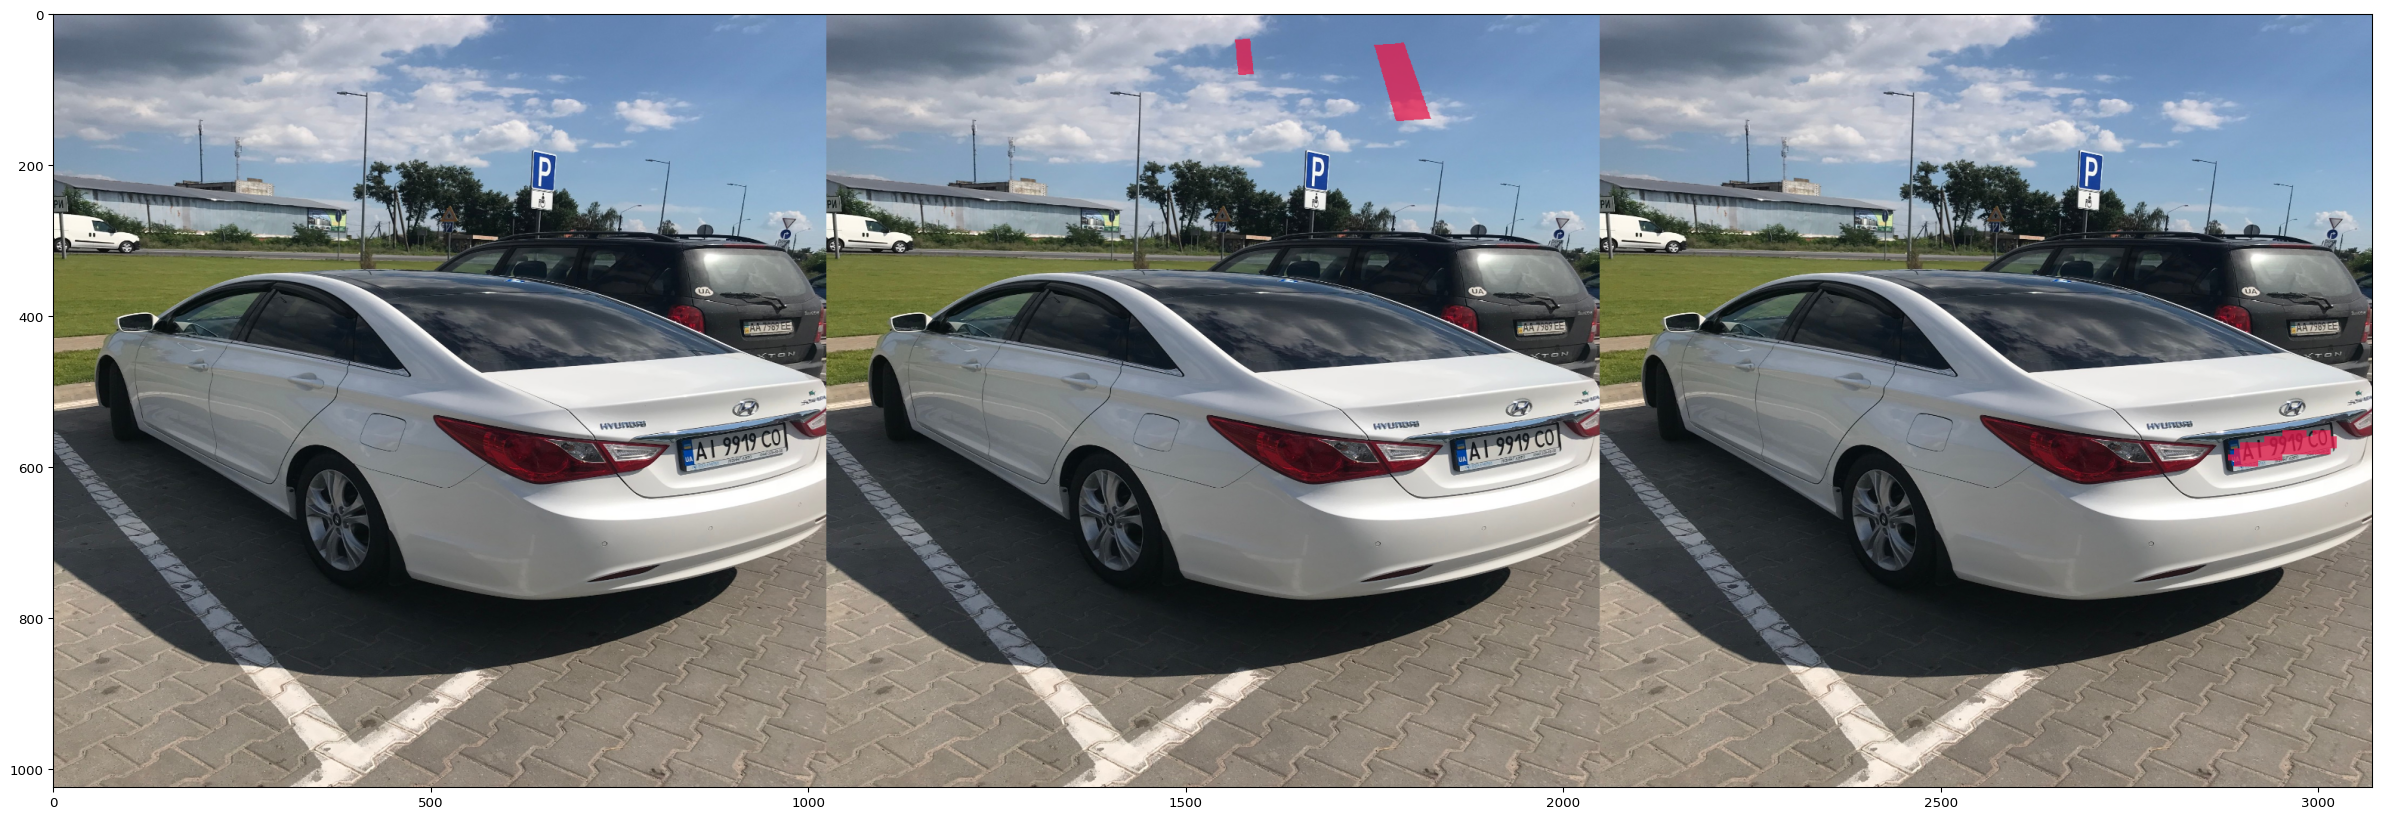

In [56]:
ia.imshow(grid_image)

In [57]:
def iou(y_true, y_pred):
    inter = (y_true.astype(np.int8) * y_pred).sum()
    if y_true.astype(np.int8).sum() + y_pred.sum() == 0:
        return 1
    iou = inter / (y_true.astype(np.int8).sum() + y_pred.sum() - inter) 
    return iou

In [35]:
iou(y[7], y_pred[7])

0.867870036101083

In [36]:
ious = []
for i in range(len(val_ds)):
    x, y_true = val_ds[i]
    y_pred = fast_scnn.predict(x)
    y_pred = np.where(y_pred > 0.4, 1, 0).astype(np.int8)
    for j in range(x.shape[0]):
        
        r = iou(y_true[j], y_pred[j])
        print(i, j, r)
        ious.append(r)

0 0 0.5896186796573156
0 1 0.8737440758293838
0 2 0.8771283939254487
0 3 0.89250217118595
0 4 0.8525966850828729
0 5 0.7483653237713562
0 6 0.7408440878967562
0 7 0.867870036101083
1 0 0.7673098751418842
1 1 0.9412918249785512
1 2 0.8471733838247227
1 3 0.9438703916315857
1 4 0.40954043048283884
1 5 0.9251160092807424
1 6 0.8531771849924095
1 7 0.8105642256902761
2 0 0.6164079822616408
2 1 0.7136758022310976
2 2 0.0
2 3 0.905838284680961
2 4 0.8935070770613346
2 5 0.7555765595463138
2 6 0.7813399095766543
2 7 0.818517758160542
3 0 0.9102684353923802
3 1 0.7719452247191011
3 2 0.8447737909516381
3 3 0.9447162935970849
3 4 0.7768869769260852
3 5 0.5176930147058824
3 6 0.8579200404858299
3 7 0.0
4 0 0.0
4 1 0.9585295457997873
4 2 0.7873641304347826
4 3 0.876878440708228
4 4 0.9034651140952202
4 5 0.9223441298206425
4 6 0.0
4 7 0.9000091987857602
5 0 0.7111111111111111
5 1 0.835814722911497
5 2 0.846993006993007
5 3 0.8813124839784671
5 4 0.6679114876539769
5 5 0.7886821310221769
5 6 0.902

46 0 0.8581304478509167
46 1 0.869970690114575
46 2 0.7390527256478999
46 3 0.8437998935604045
46 4 0.6583557951482479
46 5 0.8328663260260425
46 6 0.9273828665445163


In [37]:
np.mean(ious)

0.7356653424474712

# Freeze model

In [60]:
def freeze_session(session, output_names):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = [v.op.name for v in tf.global_variables()]
        output_names = output_names + [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        
        for node in input_graph_def.node:
            node.device = ''
            
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names,
                                                     )
        return frozen_graph

In [62]:
frozen_graph = freeze_session(K.get_session(), [out.op.name for out in fast_scnn.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 344 variables.
INFO:tensorflow:Converted 344 variables to const ops.


In [64]:
tf.train.write_graph(frozen_graph, 'model', 'fast_scnn.pb', False)

'model/fast_scnn.pb'

In [21]:
[out.op.name for out in fast_scnn.outputs]

['activation_31/Sigmoid']

In [22]:
[out.op.name for out in fast_scnn.inputs]

['input_layer']